## Context

The telecommunications provider Interconnect would like to predict customer churn. If it is discovered that a user is planning to switch providers, the company will offer them promotional codes and special plan options. The Interconnect marketing team has collected some personal data from its clientele, including information about their plans and contracts.

### **Interconnect Services**

Interconnect primarily provides two types of services:

1. Landline telephony. The phone can be connected to multiple lines at the same time.
2. Internet. The network can be established via a telephone line (DSL, *digital subscriber line*) or through a fibre optic cable.

Some additional services offered by the company include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious site blocker (*OnlineSecurity*).
- A dedicated technical support line (*TechSupport*).
- Cloud file storage and data backup (*OnlineBackup*).
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*).

Customers can choose between making monthly payments or signing a 1-year or 2-year contract. They can use various payment methods and receive an electronic invoice after the transaction.

## Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contractual information;
- `personal.csv` — customer personal data;
- `internet.csv` — information about Internet services;
- `phone.csv` — information about telephony services.

In each file, the `customerID` column contains a unique code assigned to each customer. The contractual information is valid as of 1 February 2020.

## General Resolution Plan

**Prepare the Data**
- [x] Adjust data types
- [x] Standardise column names

**Aggregate the Data into a Master DataFrame**
- [x] Concatenate the tables into a single DataFrame
- [x] Analyse correlations between variables
- [x] Explore the possibility of feature engineering
- [x] Identify the customer profile with the highest probability of churn

**Create and Train the Model**
- [x] Convert categorical variables to numerical
- [x] Split the data into training and testing sets
- [x] Train Random Forest and Gradient Boosting models. If the results are unsatisfactory, test alternative models

**Evaluate Model Performance**
- [x] Check AUC-ROC and Accuracy metrics to determine whether the model is suitable for our business problem

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.metrics import accuracy_score, roc_auc_score

## Downloading the data

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [4]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [5]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Concatenating the Tables

In [6]:
df = contract.merge(personal, on='customerID', how='outer') \
                        .merge(internet, on='customerID', how='outer') \
                        .merge(phone, on='customerID', how='outer')

I check whether the indices are unique or if there are duplicate indices after merging the tables.

In [7]:
df.index.is_unique

True

In [8]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


* Column names need to be standardised.  
* Date columns are stored as `object` instead of `datetime`.  
* The `MonthlyCharges` column is of type `float`, while `TotalCharges` is still an `object`.  
* There are many binary columns with responses limited to 'Yes' or 'No'. To optimise model training, we can convert them into numerical binary variables.  

## Preparing the data

**Standardising Column Names**

In [10]:
df = df.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})

**Converting Date Columns to Datetime Type**

Values that were previously 'No' are now converted to `NaT`.

In [11]:
for col in ['BeginDate', 'EndDate']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

**Adjusting 'TotalCharges' column to float**

In [12]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

**Converting to Numerical Binary Variables**

In [13]:
def to_binary(cols=(list)):
    for col in cols:
        df[col] = df[col].map( 
                   {'Yes':1 ,'No':0})

In [14]:
lista = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
to_binary(lista)

In [15]:
df['Gender'] = df['Gender'].map( 
                   {'Male':1 ,'Female':0})

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Gender            7043 non-null   int64         
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   float64       
 14  OnlineBackup      5517 n

When correcting the data types of the columns, we noticed the presence of missing data, which contradicts the observation made during the project planning stage.

### Handling Missing Data

In [17]:
df[df['TotalCharges'].isna()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,NaN,0,0,1,1,DSL,1.0,0.0,1.0,1.0,1.0,0.0,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,NaN,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
936,5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,NaN,0,0,1,1,DSL,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1082,4367-NUYAO,2020-02-01,NaT,Two year,0,Mailed check,25.75,NaN,1,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,0,Credit card (automatic),56.05,NaN,0,0,1,1,DSL,1.0,1.0,1.0,1.0,1.0,0.0,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,0,Mailed check,19.85,NaN,1,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3826,3213-VVOLG,2020-02-01,NaT,Two year,0,Mailed check,25.35,NaN,1,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4380,2520-SGTTA,2020-02-01,NaT,Two year,0,Mailed check,20.00,NaN,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5218,2923-ARZLG,2020-02-01,NaT,One year,1,Mailed check,19.70,NaN,1,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6670,4075-WKNIU,2020-02-01,NaT,Two year,0,Mailed check,73.35,NaN,0,0,1,1,DSL,0.0,1.0,1.0,1.0,1.0,0.0,1.0


All missing data in the `TotalCharges` column have a start date of 01/02/2020, which is the most recent date in the dataframe. This means that the contract has started, but no charges have been recorded yet.

In this case, we will fill the missing values with the corresponding values from the `MonthlyCharges` column.

In [18]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])

For `InternetService`, `Type`, and `PaymentMethod`, we applied encoding logic and created new numerical binary columns (one for each category).

In [19]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [20]:
df['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [21]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [22]:
df['DSL'] = (df['InternetService'] == 'DSL').astype(int)
df['FiberOptic'] = (df['InternetService'] == 'Fiber optic').astype(int)

df['MonthToMonth'] = (df['Type'] == 'Month-to-month').astype(int)
df['TwoYear'] = (df['Type'] == 'Two year').astype(int)
df['OneYear'] = (df['Type'] == 'One year').astype(int)

df['ElectronicCheck'] = (df['PaymentMethod'] == 'Electronic check').astype(int)
df['MailedCheck'] = (df['PaymentMethod'] == 'Mailed check').astype(int)
df['BankTransfer'] = (df['PaymentMethod'] == 'Bank transfer (automatic)').astype(int)
df['CreditCard'] = (df['PaymentMethod'] == 'Credit card (automatic)').astype(int)

We converted the `MultipleLines` column into a numerical format.

In [23]:
df['MultipleLines'] = pd.to_numeric(df['MultipleLines'], errors='coerce')

**'CustomerID' Column**

The 'CustomerID' column may be useful for tracking customers prone to leaving or for merging additional tables in the future, but it does not provide relevant information for model training. Otherwise, it could leak data, bias the model, or reduce its performance.

Therefore, we will convert this column into an index. This way, we keep the information stored while ensuring its values do not impact the model's learning process.

In [24]:
df.set_index('CustomerID', inplace=True)

## Analysing Correlations

Based on the `EndDate` column (of type datetime), we will create `Churn` (numerical), which will serve as our target column.

Additionally, we will create the `ContractDuration` column, which will indicate the duration of each contract that has ended.

In [25]:
df['Churn'] = df['EndDate'].notnull().astype(int)

In [26]:
df['ContractDuration'] = (df['EndDate'] - df['BeginDate']).dt.days
df['ContractDuration'] = df['ContractDuration'].fillna(
    (datetime.now() - df['BeginDate']).dt.days
)

In [27]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

/tmp/ipykernel_297/1978216677.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


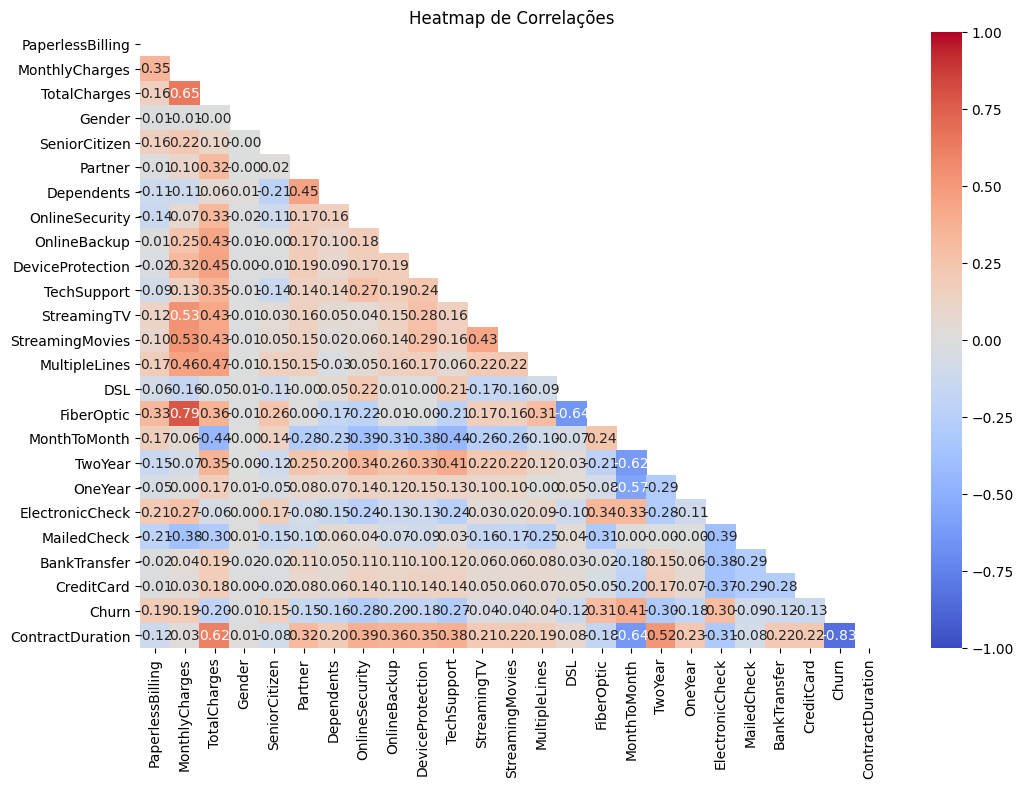

In [28]:
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(correlation_matrix, mask=mask, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Heatmap de Correlações")
plt.show()

* There is no significantly strong relationship between `Churn` and other columns.  
* A highly relevant correlation can be observed between `ContractDuration` and `TotalCharges`.  

## Defining the Customer Profile

Based on the EDA, we will examine the main characteristics of customers who cancel their plans.

In [29]:
df_churn = df[~df['EndDate'].isnull()]

In [30]:
lista_colunas = ['PaperlessBilling', 'SeniorCitizen', 'Partner', 'Dependents',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'DSL', 'FiberOptic',
       'MonthToMonth', 'TwoYear', 'OneYear', 'ElectronicCheck', 'MailedCheck',
       'BankTransfer', 'CreditCard']

In [31]:
for x in lista_colunas:
    print(x)
    print(df[x].value_counts(normalize=True))

PaperlessBilling
1    0.592219
0    0.407781
Name: PaperlessBilling, dtype: float64
SeniorCitizen
0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64
Partner
0    0.516967
1    0.483033
Name: Partner, dtype: float64
Dependents
0    0.700412
1    0.299588
Name: Dependents, dtype: float64
OnlineSecurity
0.0    0.63404
1.0    0.36596
Name: OnlineSecurity, dtype: float64
OnlineBackup
0.0    0.559724
1.0    0.440276
Name: OnlineBackup, dtype: float64
DeviceProtection
0.0    0.560993
1.0    0.439007
Name: DeviceProtection, dtype: float64
TechSupport
0.0    0.629509
1.0    0.370491
Name: TechSupport, dtype: float64
StreamingTV
0.0    0.509335
1.0    0.490665
Name: StreamingTV, dtype: float64
StreamingMovies
0.0    0.504803
1.0    0.495197
Name: StreamingMovies, dtype: float64
MultipleLines
0.0    0.532935
1.0    0.467065
Name: MultipleLines, dtype: float64
DSL
0    0.656254
1    0.343746
Name: DSL, dtype: float64
FiberOptic
0    0.560415
1    0.439585
Name: FiberOptic, dtype: floa

In [32]:
df_churn['ContractDuration'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: ContractDuration, dtype: float64

* 83.7% are senior citizens.
* 70% have no dependents.
* 55% had month-to-month contracts.
* The majority (between 51%-71%) did not subscribe to additional services such as OnlineBackup, DeviceProtection, TechSupport, StreamingTV, or StreamingMovies.
* The shortest contract lasted 30 days; 1/4 of the contracts lasted around 2 months or less. Although the average duration was 18 months, the "typical contract" (50% of the data) lasted 10 months or less.

The profile of a customer who is likely to churn is an **elderly person, without dependents, with a contract of 10 months or less, and not using any additional services**.  

## Splitting the Data into Training and Testing Sets

To train the models, we will remove the date columns.

In [33]:
df.drop(columns=['BeginDate', 'EndDate'], inplace=True)

In [34]:
Y = 'Churn'
X = [x for x in df.columns if x != Y]

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df[X], df[Y], test_size=0.25, random_state=42
)

**Predicting Missing Values with `IterativeImputer`**

Here, we will use the `IterativeImputer` method to predict the missing values based on the information from the other columns.

In [36]:
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_imputed = imputer.fit_transform(X_train[numeric_columns])
X_test_imputed = imputer.transform(X_test[numeric_columns])
X_train[numeric_columns] = pd.DataFrame(X_train_imputed, columns=numeric_columns, index=X_train.index)
X_test[numeric_columns] = pd.DataFrame(X_test_imputed, columns=numeric_columns, index=X_test.index)

In [37]:
lista2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in lista2:
    if col in X_train.columns:
        X_train[col] = (X_train[col] >= 0.5).astype(int)
        X_test[col] = (X_test[col] >= 0.5).astype(int)

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 7242-QZLXF to 4795-UXVCJ
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   float64
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float64
 4   TotalCharges      5282 non-null   float64
 5   Gender            5282 non-null   float64
 6   SeniorCitizen     5282 non-null   float64
 7   Partner           5282 non-null   float64
 8   Dependents        5282 non-null   float64
 9   InternetService   4134 non-null   object 
 10  OnlineSecurity    5282 non-null   int64  
 11  OnlineBackup      5282 non-null   int64  
 12  DeviceProtection  5282 non-null   int64  
 13  TechSupport       5282 non-null   int64  
 14  StreamingTV       5282 non-null   int64  
 15  StreamingMovies   5282 non-null   int64  
 16  MultipleLines     5282 non-null 

In [39]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1761 entries, 1024-GUALD to 3055-OYMSE
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              1761 non-null   object 
 1   PaperlessBilling  1761 non-null   float64
 2   PaymentMethod     1761 non-null   object 
 3   MonthlyCharges    1761 non-null   float64
 4   TotalCharges      1761 non-null   float64
 5   Gender            1761 non-null   float64
 6   SeniorCitizen     1761 non-null   float64
 7   Partner           1761 non-null   float64
 8   Dependents        1761 non-null   float64
 9   InternetService   1383 non-null   object 
 10  OnlineSecurity    1761 non-null   int64  
 11  OnlineBackup      1761 non-null   int64  
 12  DeviceProtection  1761 non-null   int64  
 13  TechSupport       1761 non-null   int64  
 14  StreamingTV       1761 non-null   int64  
 15  StreamingMovies   1761 non-null   int64  
 16  MultipleLines     1761 non-null 

**Removing Redundant Columns**

The columns `InternetService`, `Type`, and `PaymentMethod` are the only ones of type `object`. Since they have already been converted into numerical columns, it is safe to remove them from the DataFrame, as they now contain redundant values.

In [40]:
X_train.drop(columns=['InternetService', 'Type', 'PaymentMethod'], inplace=True)
X_test.drop(columns=['InternetService', 'Type', 'PaymentMethod'], inplace=True)
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 7242-QZLXF to 4795-UXVCJ
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PaperlessBilling  5282 non-null   float64
 1   MonthlyCharges    5282 non-null   float64
 2   TotalCharges      5282 non-null   float64
 3   Gender            5282 non-null   float64
 4   SeniorCitizen     5282 non-null   float64
 5   Partner           5282 non-null   float64
 6   Dependents        5282 non-null   float64
 7   OnlineSecurity    5282 non-null   int64  
 8   OnlineBackup      5282 non-null   int64  
 9   DeviceProtection  5282 non-null   int64  
 10  TechSupport       5282 non-null   int64  
 11  StreamingTV       5282 non-null   int64  
 12  StreamingMovies   5282 non-null   int64  
 13  MultipleLines     5282 non-null   int64  
 14  DSL               5282 non-null   float64
 15  FiberOptic        5282 non-null   float64
 16  MonthToMonth      5282 non-null 

Since the `ContractDuration` column introduces bias by leaking information related to cancellations, we will remove it from both the training and testing sets.

In [41]:
X_train = X_train.drop(columns=['ContractDuration'])
X_test = X_test.drop(columns=['ContractDuration'])

**Random Forest**

In [44]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import FitFailedWarning

rf_model = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=2,
    scoring='roc_auc'
)

grid_search_rf.fit(X_train, Y_train)

best_rf_model = grid_search_rf.best_estimator_
rf_probabilities = best_rf_model.predict_proba(X_test)[:, 1]
rf_predictions = best_rf_model.predict(X_test)

auc_roc_forest = roc_auc_score(Y_test, rf_probabilities)
accuracy_forest = accuracy_score(Y_test, rf_predictions)

print(f'AUC-ROC: {auc_roc_forest.round(2)}')
print(f'Accuracy: {accuracy_forest.round(2)}')
print(f"Best hyperparameters: {grid_search_rf.best_params_}")

AUC-ROC: 0.86
Acurácia: 0.8
Melhores hiperparâmetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


**CatBoost**

In [45]:
cat_model = CatBoostClassifier(random_state=42, verbose=0, class_weights=[1, 3])

param_grid_cat = {
    'iterations': [100, 300, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

grid_search_cat = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid_cat,
    cv=5,
    n_jobs=2,
    scoring='roc_auc'
)

grid_search_cat.fit(X_train, Y_train)

best_cat_model = grid_search_cat.best_estimator_
cat_probabilities = best_cat_model.predict_proba(X_test)[:, 1]
cat_predictions = best_cat_model.predict(X_test)

auc_roc_cat = roc_auc_score(Y_test, cat_probabilities)
accuracy_cat = accuracy_score(Y_test, cat_predictions)

print(f'AUC-ROC: {auc_roc_cat:.2f}')
print(f'Accuracy: {accuracy_cat:.2f}')
print(f'"Best hyperparameters: {grid_search_cat.best_params_}')

AUC-ROC: 0.86
Acurácia: 0.74
Melhores Hiperparâmetros: {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 7, 'learning_rate': 0.01}


**LightGBM**

In [46]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, Y_train)

param_grid_lgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 70]
}

grid_search_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid_lgb,
    cv=5, n_jobs=2,
    scoring='roc_auc'
)

grid_search_lgb.fit(X_train, Y_train)

best_lgb_model = grid_search_lgb.best_estimator_
lgb_probabilities = best_lgb_model.predict_proba(X_test)[:, 1]
lgb_predictions = best_lgb_model.predict(X_test)

auc_roc_lgb = roc_auc_score(Y_test, lgb_probabilities)
accuracy_lgb = accuracy_score(Y_test, lgb_predictions)

print(f'AUC-ROC: {auc_roc_lgb:.2f}')
print(f'Accuracy: {accuracy_lgb:.2f}')
print(f"Best hyperparameters: {grid_search_lgb.best_params_}")

AUC-ROC: 0.86
Acurácia: 0.80
Melhores hiperparâmetros: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 150, 'num_leaves': 31}


**Summary of Results**

* **Random Forest**  
  - AUC-ROC: 0.86  
  - Accuracy: 0.80  

* **CatBoost**  
  - AUC-ROC: 0.86  
  - Accuracy: 0.74  

* **LightGBM**  
  - AUC-ROC: 0.86  
  - Accuracy: 0.80  


* All models achieved the same AUC-ROC (0.86).  
* CatBoost had a lower accuracy (0.74) compared to Random Forest and LightGBM (0.80).  
* Random Forest has a high computational cost, whereas LightGBM is more efficient even with larger datasets.  

# Recommendation

Use `LightGBM` as the primary model for predicting customer churn at Interconnect, as it achieved the best overall performance among the tested models.